In [19]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

from dynaconf import Dynaconf

from llmcoder.utils import get_config_dir, get_data_dir

In [20]:
# Get all configs
config_dir = get_config_dir()
config_file_list = sorted(file for file in os.listdir(config_dir) if file.endswith(".yaml"))
config_list = [Dynaconf(settings_file=os.path.join(config_dir, config_name)) for config_name in config_file_list]
config_name_list = [os.path.splitext(config_name)[0] for config_name in config_file_list]

for config_name in config_name_list:
    print(config_name)

level_0__ft__mypy__5_steps__1_choice
level_0__ft__mypy_signature_5_steps__1_choice
level_0__ft__mypy_signature_5_steps__3_choices
level_0__ft__mypy_signature_gptscore_5_steps__3_choices
level_0__ft__mypy_signature_gptscore_hal_5_steps__3_choices
level_0__ft__mypy_signature_hal_5_steps__1_choice
level_0__ft__no_analyzers__0_step
level_0__gpt-3.5__no_analyzers__0_step
level_1__ft__mypy__5_steps__1_choice
level_1__ft__mypy_signature_5_steps__1_choice
level_1__ft__mypy_signature_5_steps__3_choices
level_1__ft__mypy_signature_gptscore_5_steps__3_choices
level_1__ft__mypy_signature_gptscore_hal_5_steps__3_choices
level_1__ft__mypy_signature_hal_5_steps__1_choice
level_1__ft__no_analyzers__0_step
level_1__gpt-3.5__no_analyzers__0_step
level_2__ft__mypy__5_steps__1_choice
level_2__ft__mypy_signature_5_steps__1_choice
level_2__ft__mypy_signature_5_steps__3_choices
level_2__ft__mypy_signature_gptscore_5_steps__3_choices
level_2__ft__mypy_signature_gptscore_hal_5_steps__3_choices
level_2__ft__myp

In [21]:
# /data/name/of/dataset/eval/<config_name>/<run_id>/metrics.csv

In [22]:
# Load all metrics.csv files into a dict
metrics_dict = {}

for config_name, config in zip(config_name_list, config_list):
    dataset = config.get('dataset')
    path_to_eval = os.path.join(get_data_dir(dataset), 'eval', config_name)

    metrics_dict[config_name] = {}

    for run_id in os.listdir(path_to_eval):
        path_to_metrics = os.path.join(path_to_eval, run_id, 'metrics.csv')
        if os.path.exists(path_to_metrics):
            with open(path_to_metrics, 'r') as f:
                metrics_dict[config_name][run_id] = pd.read_csv(f, index_col=0).astype(float)

In [23]:
# Dimensions: (config, run, example, metric)

## Average across runs

In [24]:
for k, v in metrics_dict.items():
    if len(v) == 0:
        raise ValueError(f"No metrics found for config {k}")
    metrics_dict[k]['mean'] = pd.concat(v.values()).groupby(level=0).mean()
    metrics_dict[k]['std'] = pd.concat(v.values()).groupby(level=0).std()
    metrics_dict[k]['median'] = pd.concat(v.values()).groupby(level=0).median()
    metrics_dict[k]['min'] = pd.concat(v.values()).groupby(level=0).min()
    metrics_dict[k]['max'] = pd.concat(v.values()).groupby(level=0).max()
    metrics_dict[k]['25%'] = pd.concat(v.values()).groupby(level=0).quantile(0.25)
    metrics_dict[k]['75%'] = pd.concat(v.values()).groupby(level=0).quantile(0.75)

In [25]:
# Split the metrics into `level_0`, `level_1`, and `level_2` difficulties
metrics_dict_levels = {}

for k, v in metrics_dict.items():
    level = k.split('__')[0]

    if level not in metrics_dict_levels:
        metrics_dict_levels[level] = {}

    metrics_dict_levels[level][k] = v

In [26]:
metrics_dict_levels['level_0']['level_0__ft__mypy__5_steps__1_choice']['mean']

,levenshtein_distance_score,bleu_score,trf_similarity_score,sequence_matcher_score,gpt_reviewer_score,loops_required_score,tokens_used_score,agility_score,time_score,all_analyzers_passed_score,total_tokens_generated_score
0,0.0,1.000000,1.000000,1.000000,0.0,0.0,299.0,0.0,0.567837,1.0,11.0
1,251.0,0.532686,0.869045,0.262123,0.5,0.0,1143.0,0.0,1.462953,1.0,119.0
2,336.0,0.000360,0.685173,0.192308,-1.0,5.0,3964.0,0.0,2.867468,0.0,96.0
3,242.0,0.354753,0.611753,0.398438,0.5,0.0,555.0,0.0,1.303574,1.0,111.0


In [27]:
metric_names = list(metrics_dict_levels['level_0']['level_0__ft__mypy__5_steps__1_choice']['mean'].columns)

In [28]:
for config_name in config_name_list:
    print(config_name)

level_0__ft__mypy__5_steps__1_choice
level_0__ft__mypy_signature_5_steps__1_choice
level_0__ft__mypy_signature_5_steps__3_choices
level_0__ft__mypy_signature_gptscore_5_steps__3_choices
level_0__ft__mypy_signature_gptscore_hal_5_steps__3_choices
level_0__ft__mypy_signature_hal_5_steps__1_choice
level_0__ft__no_analyzers__0_step
level_0__gpt-3.5__no_analyzers__0_step
level_1__ft__mypy__5_steps__1_choice
level_1__ft__mypy_signature_5_steps__1_choice
level_1__ft__mypy_signature_5_steps__3_choices
level_1__ft__mypy_signature_gptscore_5_steps__3_choices
level_1__ft__mypy_signature_gptscore_hal_5_steps__3_choices
level_1__ft__mypy_signature_hal_5_steps__1_choice
level_1__ft__no_analyzers__0_step
level_1__gpt-3.5__no_analyzers__0_step
level_2__ft__mypy__5_steps__1_choice
level_2__ft__mypy_signature_5_steps__1_choice
level_2__ft__mypy_signature_5_steps__3_choices
level_2__ft__mypy_signature_gptscore_5_steps__3_choices
level_2__ft__mypy_signature_gptscore_hal_5_steps__3_choices
level_2__ft__myp

In [29]:
def sorted_config_names(level=None):
    if level is None:
        return [
            f"gpt-3.5__no_analyzers__0_step",
            f"ft__no_analyzers__0_step",
            f"ft__mypy__5_steps__1_choice",
            f"ft__mypy_signature_5_steps__1_choice",
            f"ft__mypy_signature_hal_5_steps__1_choice",
            f"ft__mypy_signature_5_steps__3_choices",
            f"ft__mypy_signature_gptscore_5_steps__3_choices",
            f"ft__mypy_signature_gptscore_hal_5_steps__3_choices"
        ]
    else:
        return [
            f"level_{level}__gpt-3.5__no_analyzers__0_step",
            f"level_{level}__ft__no_analyzers__0_step",
            f"level_{level}__ft__mypy__5_steps__1_choice",
            f"level_{level}__ft__mypy_signature_5_steps__1_choice",
            f"level_{level}__ft__mypy_signature_hal_5_steps__1_choice",
            f"level_{level}__ft__mypy_signature_5_steps__3_choices",
            f"level_{level}__ft__mypy_signature_gptscore_5_steps__3_choices",
            f"level_{level}__ft__mypy_signature_gptscore_hal_5_steps__3_choices"
        ]

def config_name_short(config_name):
    if 'level' in config_name:
        config_name = '__'.join(config_name.split('__')[1:])
    match config_name:
        case 'gpt-3.5__no_analyzers__0_step': return 'GPT-3.5, 0 step'
        case 'ft__no_analyzers__0_step': return 'FT, 0 step'
        case 'ft__mypy__5_steps__1_choice': return 'FT+Mypy'
        case 'ft__mypy_signature_5_steps__1_choice': return 'FT+Mypy+Sig'
        case 'ft__mypy_signature_hal_5_steps__1_choice': return 'FT+Mypy+Sig+Hal'
        case 'ft__mypy_signature_5_steps__3_choices': return 'FT+Mypy+Sig, 3 choices'
        case 'ft__mypy_signature_gptscore_5_steps__3_choices': return 'FT+Mypy+Sig+GPT, 3 choices'
        case 'ft__mypy_signature_gptscore_hal_5_steps__3_choices': return 'FT+Mypy+Sig+GPT+Hal, 3 choices'
        case _: return config_name

def maximize_or_minimize(metric_name):
    return {
        "levenshtein_distance_score": -1,
        "bleu_score": 1,
        "trf_similarity_score": 1,
        "sequence_matcher_score": 1,
        "gpt_reviewer_score": 1,
        "loops_required_score": -1,
        "tokens_used_score": -1,
        "agility_score": 1,
        "time_score": -1,
        "all_analyzers_passed_score": 1,
        "total_tokens_generated_score": -1
    }[metric_name]

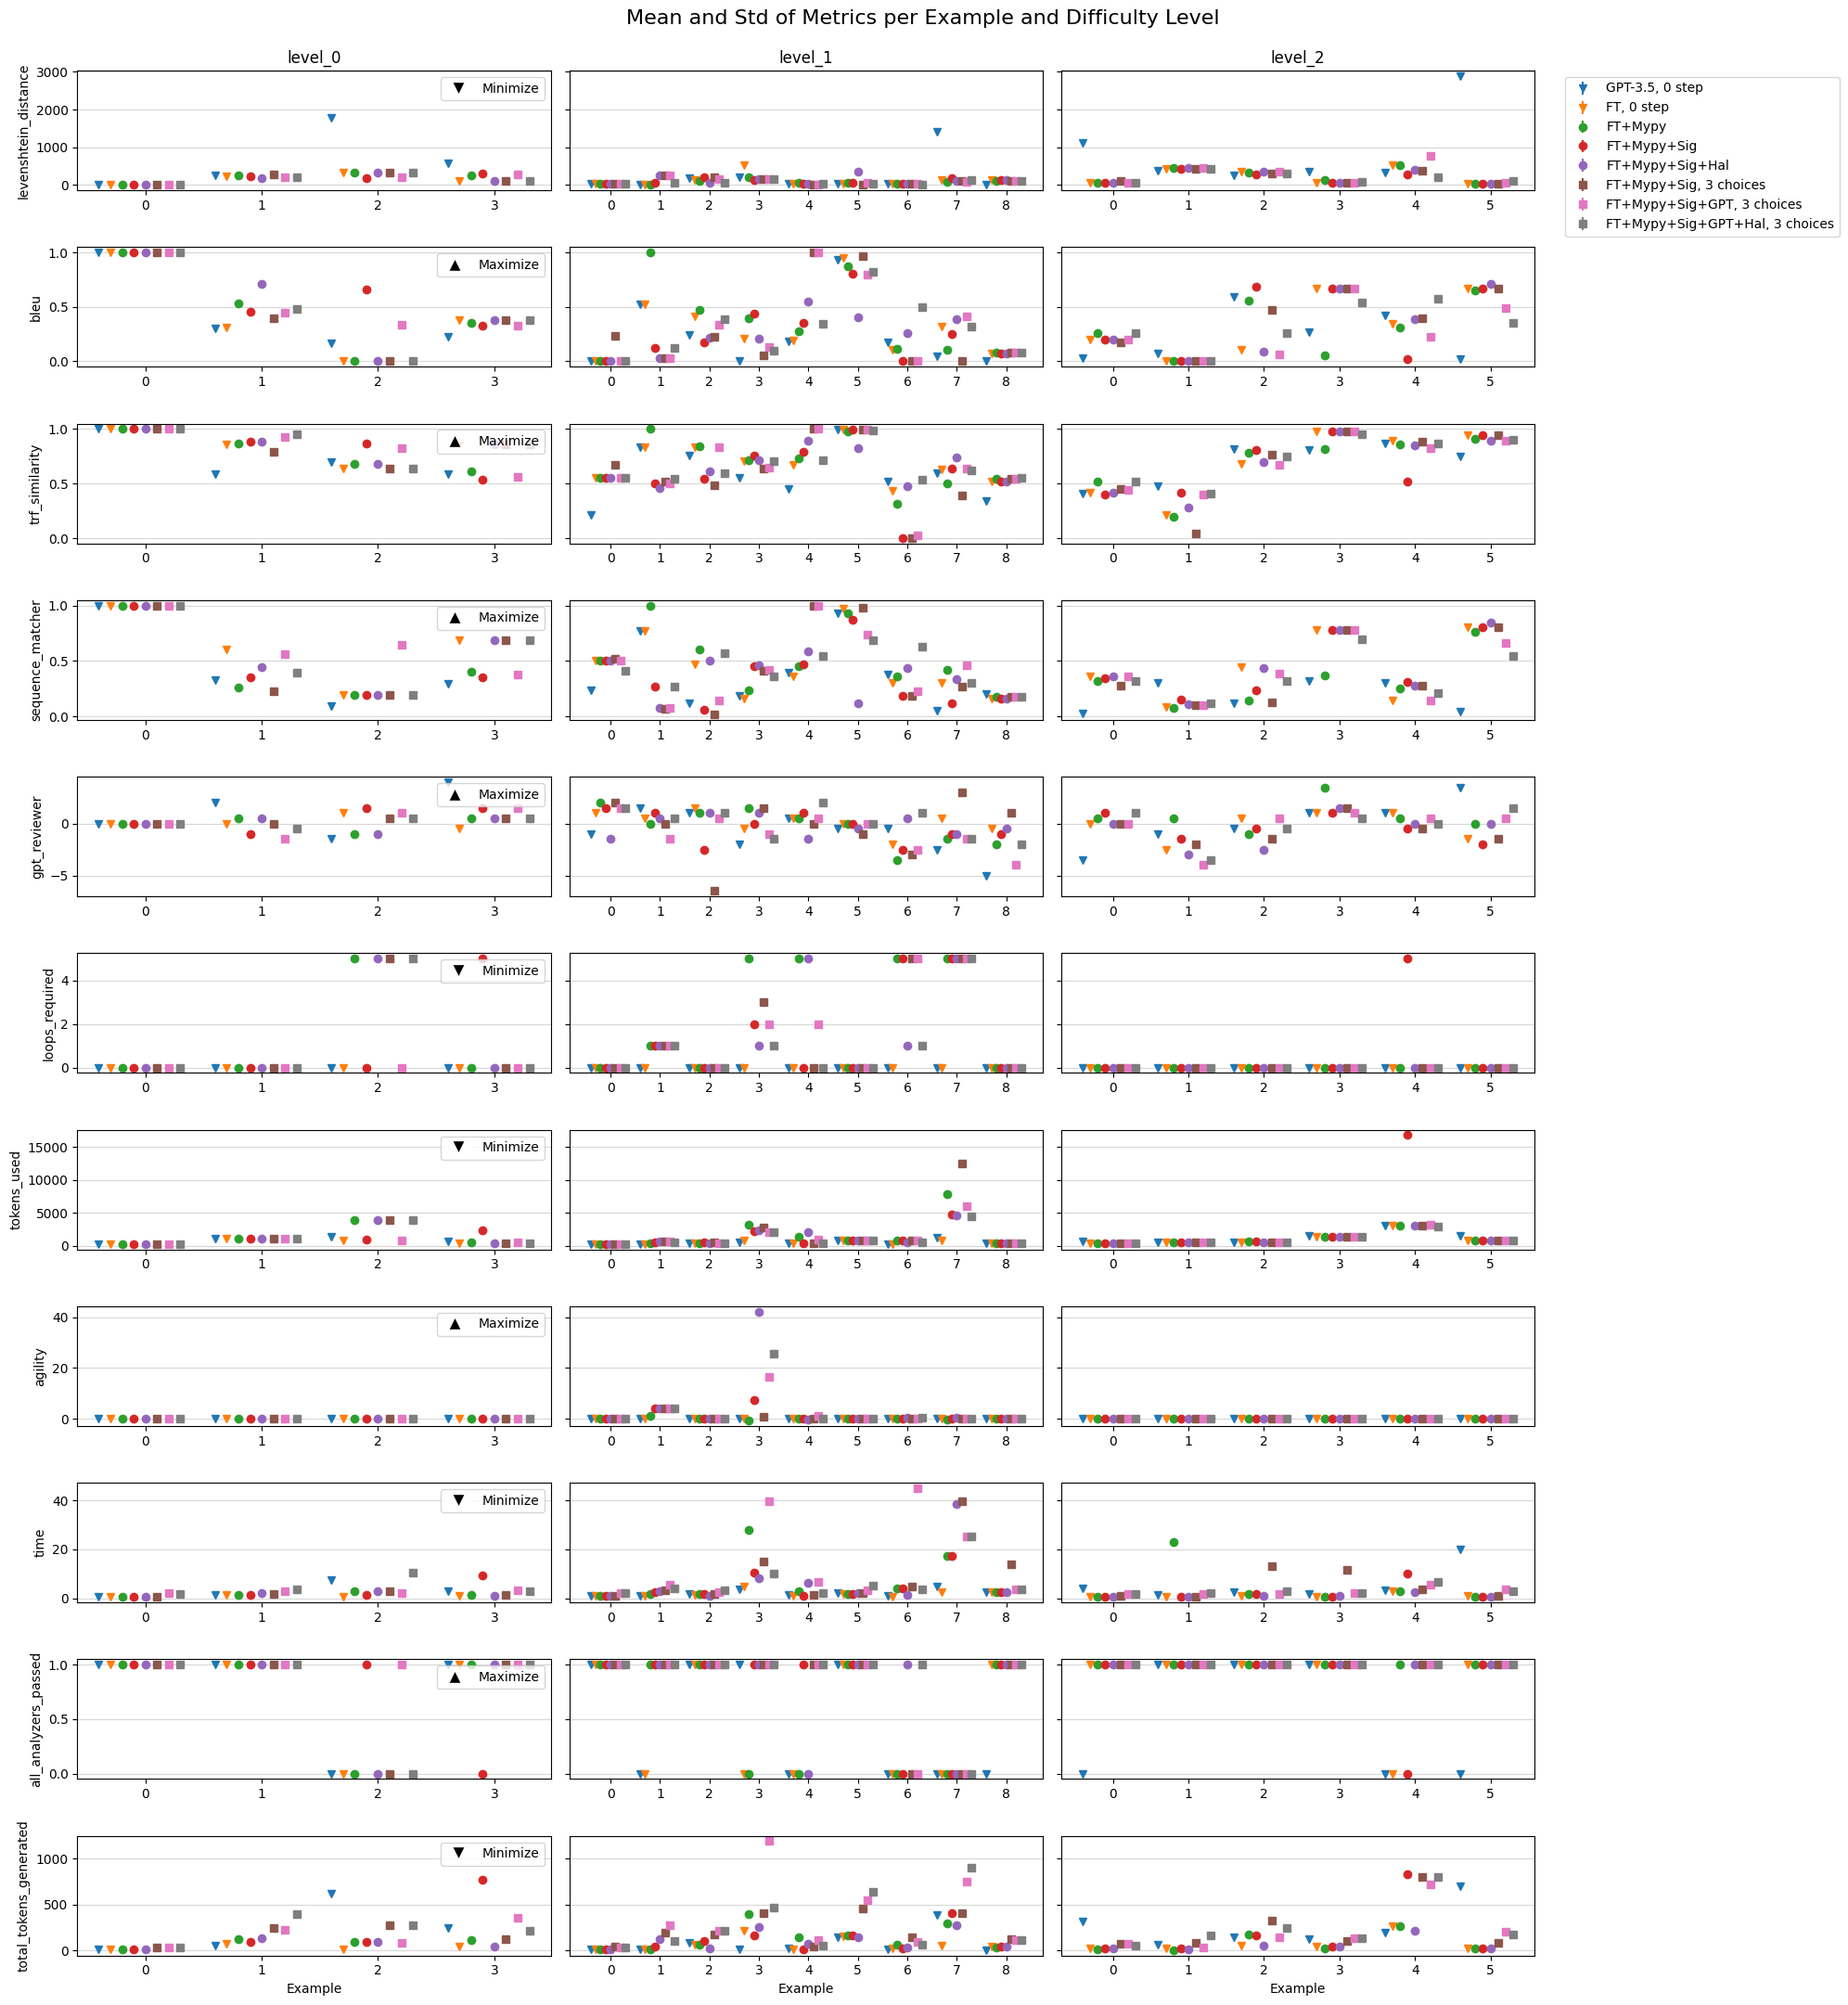

In [30]:
fig, axes = plt.subplots(len(metric_names), 3, figsize=(20, len(metric_names)*2), sharey='row')

for i, (metric, ax_row) in enumerate(zip(metric_names, axes)):
    for level, ax in enumerate(ax_row):
        for c, config_name in enumerate(sorted_config_names(level)):
            metrics = metrics_dict_levels[f'level_{level}'][config_name]

            x = metrics['mean'].index + 0.1 * (c - len(sorted_config_names(level)) / 2)
            y = metrics['mean'][metric]
            yerr = metrics['std'][metric]

            if '3_choice' in config_name:
                fmt = 's'
            elif '0_step' in config_name:
                fmt = 'v'
            else:
                fmt = 'o'

            ax.errorbar(x, y, yerr=yerr, fmt=fmt, label=config_name_short(config_name))

            ax.set_xticks(metrics['mean'].index)

        if i == 0:
            ax.set_title(f'level_{level}')
        elif i == len(metric_names) - 1:
            ax.set_xlabel('Example')

        if level == 0:
            ax.set_ylabel('_'.join(metric.split('_')[:-1]))

            # Add a legend stating whether the metric is subject to minimization or maximization
            if maximize_or_minimize(metric) == 1:
                handles = [plt.Line2D([0], [0], marker='^', color='w', label='Maximize', markerfacecolor='k', markersize=10)]
            else:
                handles = [plt.Line2D([0], [0], marker='v', color='w', label='Minimize', markerfacecolor='k', markersize=10)]

            ax.legend(handles=handles, loc='upper right')

        ax.grid(axis='y', alpha=0.5)


axes[0, -1].legend(bbox_to_anchor=(1.05, 1), loc='upper left')

fig.tight_layout()

fig.suptitle('Mean and Std of Metrics per Example and Difficulty Level', fontsize=16) 
fig.subplots_adjust(top=0.95)

In [31]:
# Now, compute the mean and std of the metrics across all examples
metrics_dict = {
    'mean': {},
    'std': {},
    'median': {},
    'min': {},
    'max': {},
    '25%': {},
    '75%': {},
}

# Concatenate all raw dataframes into a single dataframe
metrics_dict_config_list = {'__'.join(config_name.split('__')[1:]): [] for config_name in config_name_list}

for k, v in metrics_dict_levels.items():
    for k2, v2 in v.items():
        config_name = '__'.join(k2.split('__')[1:])
        for k3, v3 in v2.items():
            metrics_dict_config_list[config_name].append(v3)

for config_name, metrics_list in metrics_dict_config_list.items():
    metrics_dict_config_list[config_name] = pd.concat(metrics_list)

In [32]:
metrics_dict_config_list.keys()

dict_keys(['ft__mypy__5_steps__1_choice', 'ft__mypy_signature_5_steps__1_choice', 'ft__mypy_signature_5_steps__3_choices', 'ft__mypy_signature_gptscore_5_steps__3_choices', 'ft__mypy_signature_gptscore_hal_5_steps__3_choices', 'ft__mypy_signature_hal_5_steps__1_choice', 'ft__no_analyzers__0_step', 'gpt-3.5__no_analyzers__0_step'])

In [33]:
sorted_config_names()

['gpt-3.5__no_analyzers__0_step',
 'ft__no_analyzers__0_step',
 'ft__mypy__5_steps__1_choice',
 'ft__mypy_signature_5_steps__1_choice',
 'ft__mypy_signature_hal_5_steps__1_choice',
 'ft__mypy_signature_5_steps__3_choices',
 'ft__mypy_signature_gptscore_5_steps__3_choices',
 'ft__mypy_signature_gptscore_hal_5_steps__3_choices']

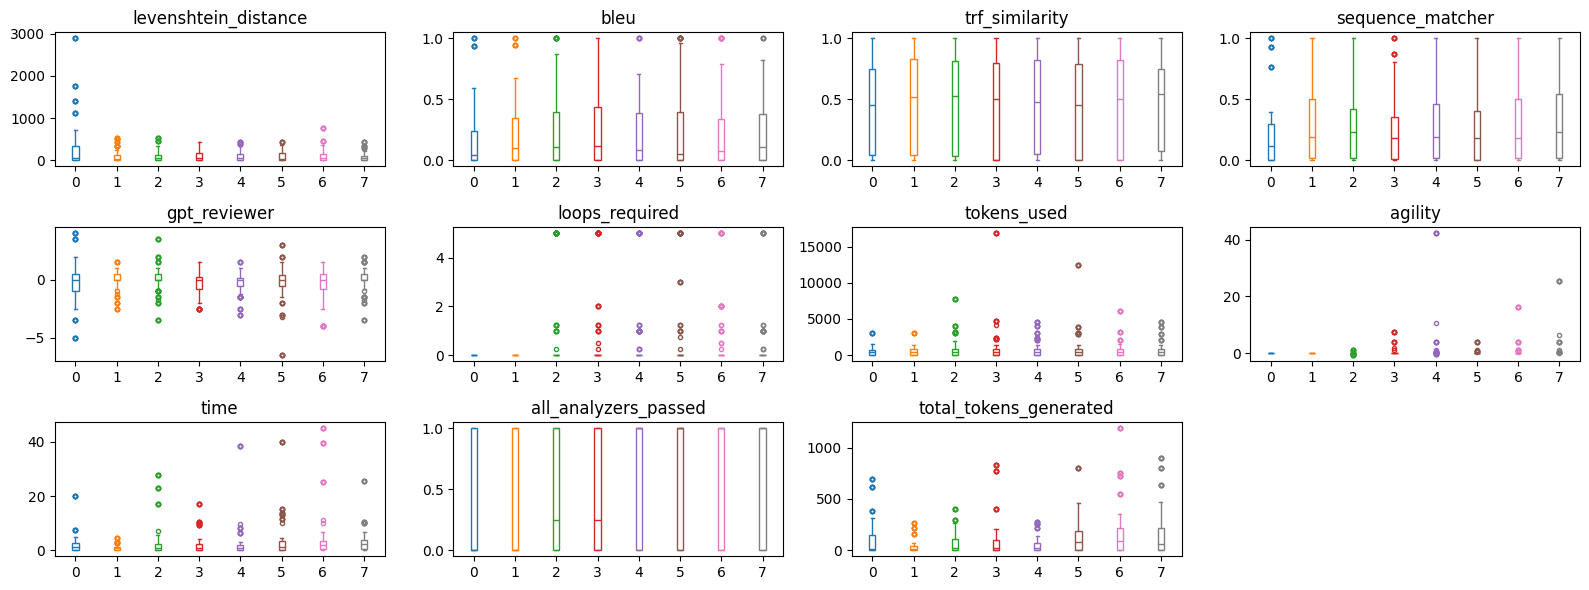

In [34]:
COLS = 4
ROWS = int(np.ceil(len(metric_names) / COLS))

fig, axes = plt.subplots(ROWS, COLS, figsize=(16, ROWS*2))

# For each metric (axis), shot a boxplot for each config (color)
for i, (metric, ax) in enumerate(zip(metric_names, axes.flatten())):
    for j, config_name in enumerate(sorted_config_names()):
        box = ax.boxplot(metrics_dict_config_list[config_name][metric], positions=[j], patch_artist=True)
        box['boxes'][0].set_facecolor('white')
        box['boxes'][0].set_edgecolor('C{}'.format(j))
        box['medians'][0].set_color('C{}'.format(j))
        box['whiskers'][0].set_color('C{}'.format(j))
        box['whiskers'][1].set_color('C{}'.format(j))
        box['caps'][0].set_color('C{}'.format(j))
        box['caps'][1].set_color('C{}'.format(j))
        box['fliers'][0].set_color('C{}'.format(j))
        box['fliers'][0].set_markeredgecolor('C{}'.format(j))
        # box['fliers'][0].set_markerfacecolor('C{}'.format(j))
        box['fliers'][0].set_markersize(3)
        box['fliers'][0].set_marker('o')
        

        ax.set_title('_'.join(metric.split('_')[:-1]))

for ax in axes.flatten()[len(metric_names):]:
    ax.set_visible(False)

fig.tight_layout()

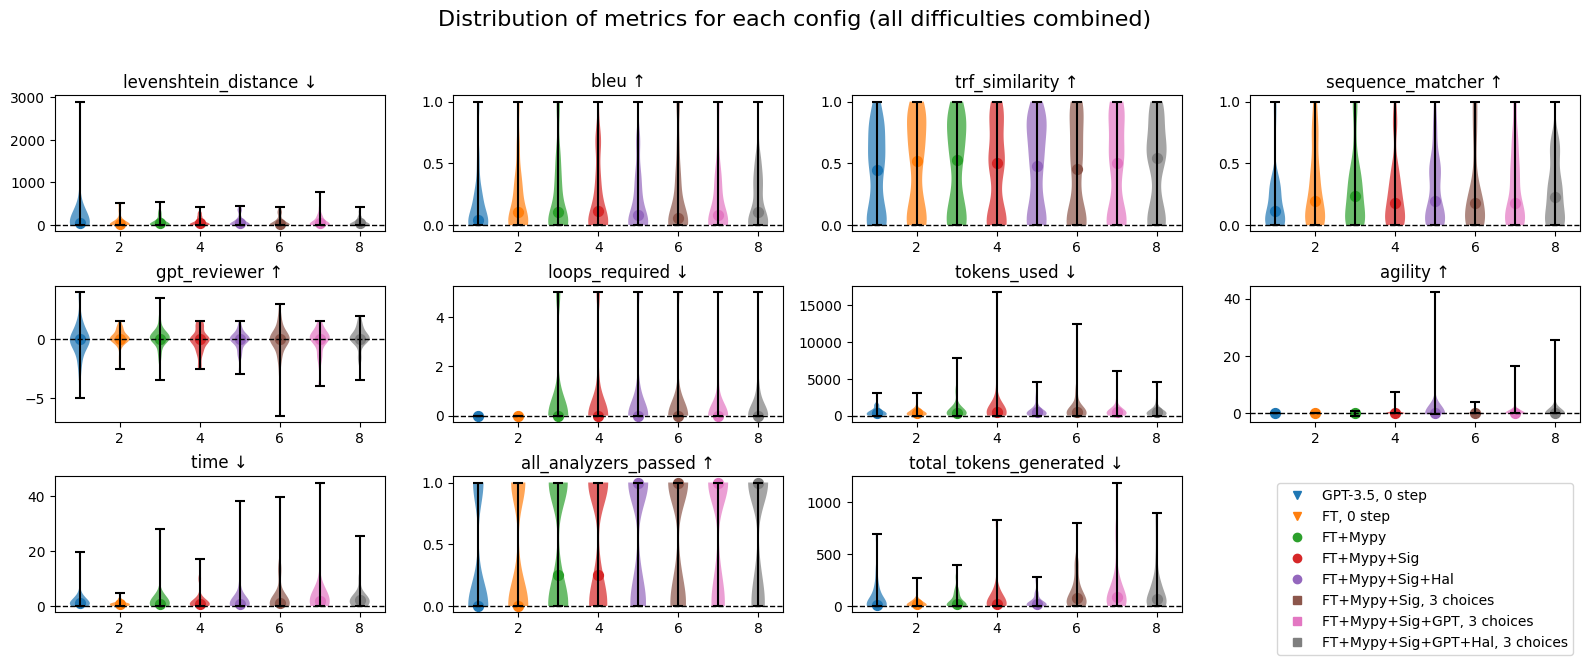

In [36]:
COLS = 4
ROWS = int(np.ceil(len(metric_names) / COLS))

fig, axes = plt.subplots(ROWS, COLS, figsize=(16, ROWS*2.2))

# For each metric (axis), show a violin plot for each config (color)
for i, (metric, ax) in enumerate(zip(metric_names, axes.flatten())):
    data_to_plot = [metrics_dict_config_list[config_name][metric] for config_name in sorted_config_names()]
    parts = ax.violinplot(data_to_plot)

    # Customize the violin plot colors
    for pc, j in zip(parts['bodies'], range(len(sorted_config_names()))):
        pc.set_facecolor(f'C{j}')
        pc.set_alpha(0.7)

    for pc in [parts['cbars'], parts['cmins'], parts['cmaxes']]:
        pc.set_edgecolor('black')

    # Set plot title
    ax.set_title('_'.join(metric.split('_')[:-1]) + (' ↑' if maximize_or_minimize(metric) == 1 else ' ↓'))

    # Plot the 0 line without changing the y-axis limits
    ax.axhline(0, color='black', linewidth=1, linestyle='--')

    # Show the median value for each config
    for j, config_name in enumerate(sorted_config_names()):
        ax.scatter(j + 1, metrics_dict_config_list[config_name][metric].median(), color=f'C{j}', marker='o', s=50)

for ax in axes.flatten()[len(metric_names):-1]:
    ax.set_visible(False)

# In the last axis, plot the legend
ax = axes.flatten()[-1]
for j, config_name in enumerate(sorted_config_names()):
    if '3_choice' in config_name:
        fmt = 's'
    elif '0_step' in config_name:
        fmt = 'v'
    else:
        fmt = 'o'

    ax.errorbar([], [], fmt=fmt, label=config_name_short(config_name), color=f'C{j}')

ax.legend()
ax.set_axis_off()

fig.tight_layout()

fig.suptitle('Distribution of metrics for each config (all difficulties combined)', fontsize=16)
fig.subplots_adjust(top=0.85)